### The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. 

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, explained_variance_score

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7617 entries, 0 to 7616
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7617 non-null   float64
 1   bath            7617 non-null   float64
 2   acre_lot        7617 non-null   float64
 3   zip_code        7617 non-null   float64
 4   house_size      7617 non-null   float64
 5   prev_sold_date  7617 non-null   object 
 6   price           7617 non-null   float64
dtypes: float64(6), object(1)
memory usage: 416.7+ KB


#### Create new feature prev_sold_year from prev_sold_date

In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7617 entries, 0 to 7616
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7617 non-null   float64
 1   bath            7617 non-null   float64
 2   acre_lot        7617 non-null   float64
 3   zip_code        7617 non-null   float64
 4   house_size      7617 non-null   float64
 5   price           7617 non-null   float64
 6   prev_sold_year  7617 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 416.7 KB


#### Create a new feature in the housing data for Zip Code with a leading zero

In [5]:
outliers_df["zip_code_str"] = np.where(outliers_df.zip_code.apply(int) < 10000,'0'+ outliers_df.zip_code.apply(int).apply(str),outliers_df.zip_code.apply(int).apply(str))
outliers_df.head()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,zip_code_str
0,3.0,2.0,0.14,7001.0,1542.0,305100.0,2022,07001
1,3.0,2.0,0.11,7001.0,1500.0,479000.0,2016,07001
2,3.0,2.0,0.17,7001.0,7501.0,340000.0,2021,07001
3,5.0,2.0,0.18,7001.0,1387.0,484000.0,2020,07001
4,3.0,2.0,0.17,7001.0,1500.0,425000.0,2019,07001


#### Create a new feature in the Lat/Long data for Zip Code with a leading zero

In [6]:
zip_lon_lat = pd.read_csv('nj_zip-lon-lat.csv')
zip_lon_lat["zip_code_str"] = np.where(zip_lon_lat.zip_code.apply(int) < 10000,'0'+ zip_lon_lat.zip_code.apply(int).apply(str),zip_lon_lat.zip_code.apply(int).apply(str))
zip_lon_lat.head()

,zip_code,latitude,longitude,zip_code_str
0,7001,40.582316,-74.271506,07001
1,7002,40.662338,-74.110275,07002
2,7003,40.809128,-74.187155,07003
3,7004,40.882508,-74.304593,07004
4,7005,40.932771,-74.417304,07005


#### Merge the Lat/Long data with the housing data using Zip Code with a leading zero

In [7]:
merged_df = pd.merge(outliers_df, zip_lon_lat, how='inner', on="zip_code_str")
merged_df.tail()

,bed,bath,acre_lot,zip_code_x,house_size,price,prev_sold_year,zip_code_str,zip_code_y,latitude,longitude
7609,5.0,4.0,0.91,8848.0,1500.0,485000.0,2017,08848,8848,40.594266,-75.096659
7610,4.0,3.0,2.17,8825.0,1500.0,510000.0,2016,08825,8825,40.514169,-75.027112
7611,3.0,2.0,0.12,7012.0,1500.0,499000.0,2021,07012,7012,40.848398,-74.160266
7612,3.0,3.0,0.13,7012.0,1500.0,530000.0,2022,07012,7012,40.848398,-74.160266
7613,4.0,3.0,0.11,7640.0,1500.0,720000.0,2016,07640,7640,40.991681,-73.980202


#### Create common variables to store frequently used values.

In [8]:
features = ["latitude","longitude","bed","bath","acre_lot","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [9]:
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [10]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [11]:
def print_more_stuff(title, y_param, predict_param, gscv):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    #find_best_params = gscv.cv_results_["params"].index(gscv.best_params_)
    #mean_fit_time = gscv.cv_results_["mean_fit_time"][find_best_params]
    mean_fit_time = gscv.cv_results_["mean_fit_time"][gscv.best_index_]
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)
    results_dict["mean fit time"].append(mean_fit_time)
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)
    print(title + " Fit Time = " + str(mean_fit_time))

#### Create common variables that will be used in the Notebook

In [12]:
lasso = Lasso(random_state=42)
lasso_sfs = SequentialFeatureSelector(estimator=lasso, n_features_to_select=num_features_to_select)
lasso_sfm = SelectFromModel(estimator=lasso, threshold=1000)
lasso_rfe = RFE(estimator=lasso, n_features_to_select=num_features_to_select)

#### Use Grid Search CV to find the best Hyperparameters for Lasso Regression

In [13]:
myrange = []
for i in range(12,17):
    myrange.append(10**-i)
param_dict = {'alpha': myrange}
lasso_gscv = GridSearchCV(Lasso(), param_grid=param_dict, scoring='neg_mean_squared_error')
lasso_gscv_model = lasso_gscv.fit(X, y)
print(f"Best parameters found: {lasso_gscv.best_params_}")

Best parameters found: {'alpha': 1e-12}


In [14]:
lasso = Lasso(**lasso_gscv.best_params_)
lasso_bp_gscv = GridSearchCV(lasso, param_grid={})
lasso_bp_model = lasso_bp_gscv.fit(X_train,y_train)
lasso_bp_predict = lasso_bp_model.predict(X_test)

print_more_stuff("Lasso Best Params", y_test, lasso_bp_predict, lasso_bp_gscv)

Lasso Best Params EVS = 0.347887513
Lasso Best Params MSE = 104,946,356,936.655273
Lasso Best Params MAE = 204,367.794129
Lasso Best Params R2 = 0.347888
Lasso Best Params Fit Time = 0.7910299301147461


### SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter.

In [15]:
lasso_sfm_pipeline = Pipeline([
  ('feature_selection', lasso_sfm),
  ('regression', lasso)
])

lasso_sfm_fs = lasso_sfm_pipeline.named_steps['feature_selection'].fit(X,y)
lasso_sfm_selected_features = lasso_sfm_fs.get_support()

print('The selected features are:', list(X.columns[lasso_sfm_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'acre_lot', 'prev_sold_year']


In [16]:
X_sfm = merged_df[list(X.columns[lasso_sfm_selected_features])]
y_sfm = merged_df["price"]
X_sfm_train, X_sfm_test, y_sfm_train, y_sfm_test = train_test_split(X_sfm, y_sfm, test_size=0.3, random_state=random_state_value)

In [17]:
lasso_sfm_gscv = GridSearchCV(Lasso(), param_grid={})
lasso_sfm_model = lasso_sfm_gscv.fit(X_sfm_train,y_sfm_train)
lasso_sfm_predict = lasso_sfm_model.predict(X_sfm_test)

print_more_stuff("Select From Model",y_sfm_test,lasso_sfm_predict,lasso_sfm_gscv)

Select From Model EVS = 0.335563247
Select From Model MSE = 106,931,453,467.396774
Select From Model MAE = 205,646.105541
Select From Model R2 = 0.335553
Select From Model Fit Time = 0.00313420295715332


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [18]:
lasso_sfs_pipeline = Pipeline([
  ('feature_selection', lasso_sfs),
  ('regression', lasso)
])

lasso_sfs_fs = lasso_sfs_pipeline.named_steps['feature_selection'].fit(X,y)
lasso_sfs_selected_features = lasso_sfs_fs.get_support()

print('The selected features are:', list(X.columns[lasso_sfs_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size', 'prev_sold_year']


In [19]:
X_sfs = merged_df[list(X.columns[lasso_sfs_selected_features])]
y_sfs = merged_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [20]:
lasso_sfs_gscv = GridSearchCV(Lasso(), param_grid={})
lasso_sfs_model = lasso_sfs_gscv.fit(X_sfs_train,y_sfs_train)
lasso_sfs_predict = lasso_sfs_model.predict(X_sfs_test)

print_more_stuff("Sequential Feature Selector",y_sfs_test,lasso_sfs_predict, lasso_sfs_gscv)

Sequential Feature Selector EVS = 0.388513446
Sequential Feature Selector MSE = 98,409,733,123.653152
Sequential Feature Selector MAE = 203,265.350341
Sequential Feature Selector R2 = 0.388505
Sequential Feature Selector Fit Time = 0.01019439697265625


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [21]:
lasso_rfe_pipeline = Pipeline([
  ('feature_selection', lasso_rfe),
  ('regression', lasso)
])
lasso_rfe_fs = lasso_rfe_pipeline.named_steps['feature_selection'].fit(X,y)
lasso_rfe_selected_features = lasso_rfe_fs.get_support()

print('The selected features are:', list(X.columns[lasso_rfe_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'acre_lot', 'prev_sold_year']


In [22]:
X_rfe = merged_df[list(X.columns[lasso_rfe_selected_features])]
y_rfe = merged_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [23]:
lasso_rfe_gscv = GridSearchCV(Lasso(), param_grid={})
lasso_rfe_model = lasso_rfe_gscv.fit(X_rfe_train,y_rfe_train)
lasso_rfe_predict = lasso_rfe_model.predict(X_rfe_test)

print_more_stuff("Recursive Feature Elimination",y_rfe_test,lasso_rfe_predict, lasso_rfe_gscv)

Recursive Feature Elimination EVS = 0.335563247
Recursive Feature Elimination MSE = 106,931,453,467.396774
Recursive Feature Elimination MAE = 205,646.105541
Recursive Feature Elimination R2 = 0.335553
Recursive Feature Elimination Fit Time = 0.011481761932373047


#### Graphing the results works best when the data is provided in a DataFrame.

In [24]:
lasso_bp_predict_df = pd.DataFrame(lasso_bp_predict).reset_index()
lasso_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfm_predict_df = pd.DataFrame(lasso_sfm_predict).reset_index()
lasso_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfs_predict_df = pd.DataFrame(lasso_sfs_predict).reset_index()
lasso_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_rfe_predict_df = pd.DataFrame(lasso_rfe_predict).reset_index()
lasso_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

#### Scatter Plot graph of the results of Recursive Feature Elimination, Sequential Feature Selection, Select From Model, and Test Data.

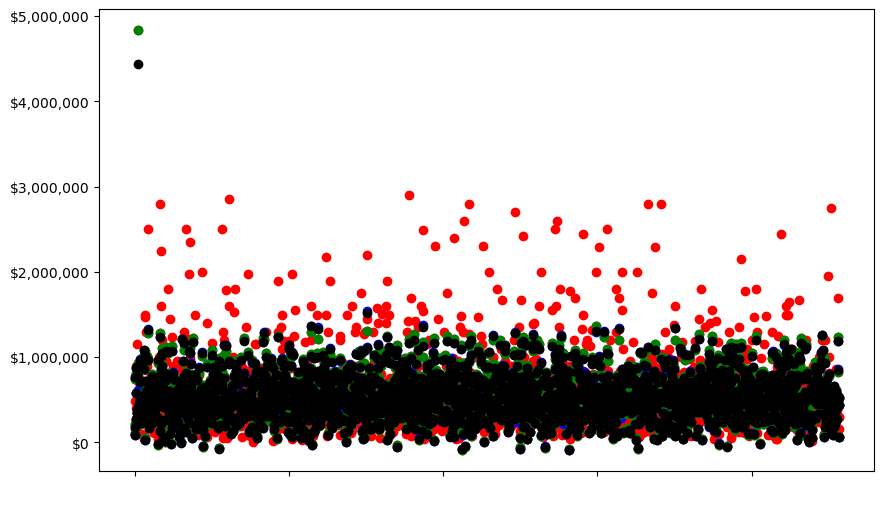

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(lasso_sfm_predict_df.index,lasso_sfm_predict_df["prediction"], color="brown")
plt.scatter(lasso_sfs_predict_df.index,lasso_sfs_predict_df["prediction"], color="blue")
plt.scatter(lasso_rfe_predict_df.index,lasso_rfe_predict_df["prediction"], color="green")
plt.scatter(lasso_bp_predict_df.index,lasso_bp_predict_df["prediction"], color="black")
plt.show()

#### Sort the DataFrames by the Prediction and Price features.

In [26]:
lasso_bp_predict_df.sort_values(by='prediction', inplace=True)
lasso_bp_predict_df.reset_index(inplace=True)

lasso_sfm_predict_df.sort_values(by='prediction', inplace=True)
lasso_sfm_predict_df.reset_index(inplace=True)

lasso_sfs_predict_df.sort_values(by='prediction', inplace=True)
lasso_sfs_predict_df.reset_index(inplace=True)

lasso_rfe_predict_df.sort_values(by='prediction', inplace=True)
lasso_rfe_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

#### Line graph of the results of Recursive Feature Elimination, Sequential Feature Selection, Select From Model, and Test Data.

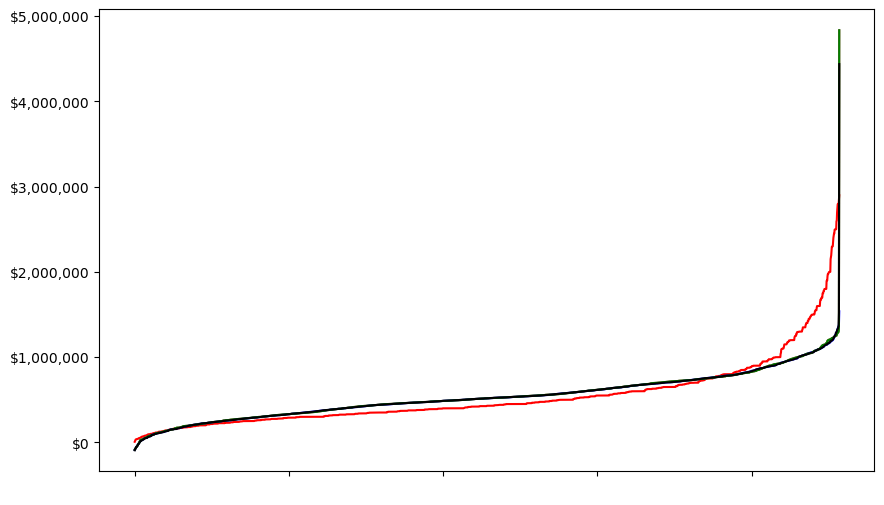

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(lasso_sfm_predict_df.index,lasso_sfm_predict_df["prediction"], color="brown")
plt.plot(lasso_sfs_predict_df.index,lasso_sfs_predict_df["prediction"], color="blue")
plt.plot(lasso_rfe_predict_df.index,lasso_rfe_predict_df["prediction"], color="green")
plt.plot(lasso_bp_predict_df.index,lasso_bp_predict_df["prediction"], color="black")
plt.show()

In [28]:
results_dict

{'model': ['Lasso Best Params',
  'Select From Model',
  'Sequential Feature Selector',
  'Recursive Feature Elimination'],
 'explained variance score': ['0.347887513',
  '0.335563247',
  '0.388513446',
  '0.335563247'],
 'mae score': ['204,367.794129',
  '205,646.105541',
  '203,265.350341',
  '205,646.105541'],
 'mse score': ['104,946,356,936.655273',
  '106,931,453,467.396774',
  '98,409,733,123.653152',
  '106,931,453,467.396774'],
 'r2 score': ['0.347888', '0.335553', '0.388505', '0.335553'],
 'mean fit time': [0.7910299301147461,
  0.00313420295715332,
  0.01019439697265625,
  0.011481761932373047]}

In [29]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Lasso Best Params,0.347887513,"204,367.794129","104,946,356,936.655273",0.347888,0.791030
Select From Model,0.335563247,"205,646.105541","106,931,453,467.396774",0.335553,0.003134
Sequential Feature Selector,0.388513446,"203,265.350341","98,409,733,123.653152",0.388505,0.010194
Recursive Feature Elimination,0.335563247,"205,646.105541","106,931,453,467.396774",0.335553,0.011482
